In [25]:
from src.data_structures.features import *
from src.data_structures.Instance import Instance
from src.solvers.DLHeu import DLHeu
from src.solvers.collection import SolverCollection,Solution,SolverConfig
from fastai.tabular.all import slide,valley
from pathlib import Path

In [26]:

#Estas van a vivir en memoria, para poder reentrenar el modelo con nuevas features, sin tener que recalcular soluciones y otras cosillas

from random import shuffle


data_path = Path("./training_data")
instances = map(Instance.from_file,data_path.iterdir())
instances = list(instances)
shuffle(instances)
instances = list(instances)[:100]



In [27]:
from src.data_structures.features import ItemBatchFeature, ItemSingleFeature


In [28]:
from src.data_structures import Instance


class ExperimentalFeature(ItemBatchFeature):
    name = "Experimental"

    @staticmethod
    def batch_evaluate(instance: Instance) -> float:
        """Average of """
        syns = [list([0,0]) for i in range(instance.n_items)]
        for pol_gain, value in instance.polynomial_gains.items():
            if value < 0:
                reference = 0
            else:
                reference = 1
            for item in instance.key_to_set(pol_gain):
                syns[item][reference] += 1*value
        syns = np.array(syns)
        salida = syns[:,1]/instance.budget
        
        return salida

In [29]:
from src.data_structures import Instance
from numpy import std
from random import random


class Noise(ItemBatchFeature):
    """Para medir si otras features son tan utiles como el ruido"""
    name = "Noise"
    @staticmethod
    def batch_evaluate(instance: Instance) -> ArrayLike:
        """Average of """
        salida = np.random.random(instance.n_items)
        return salida

In [30]:
class ExperimentalFeature(ItemBatchFeature):
    name = "Experimental"
    @staticmethod
    def batch_evaluate(instance: Instance) -> float:
        """Average of """
        syns = [list([0,0]) for i in range(instance.n_items)]
        for pol_gain, value in instance.polynomial_gains.items():
            if value < 0:
                reference = 0
            else:
                reference = 1
            for item in instance.key_to_set(pol_gain):

                syns[item][reference] += instance.costs[item][0]*value
        syns = np.array(syns)
        salida = syns[:,1]/instance.budget
        
        return salida

In [31]:
class Budget(ItemBatchFeature):
    name = "Budget"
    @staticmethod
    def batch_evaluate(instance: Instance) -> float:
        """Normalized Budget?"""
        return np.array([ instance.budget/instance.n_items  for i in range(instance.n_items)])

In [32]:
from numpy.typing import ArrayLike
from src.data_structures import Instance


class StdOfItemProfits(ItemBatchFeature):
    name = "STDIP"
    
    @staticmethod
    def batch_evaluate(instance: Instance) -> ArrayLike:
        singular_value = np.std([instance.profits[i] for i in range(instance.n_items)])
        return np.array([singular_value for i in range(instance.n_items)])
    
class StdOfItemSyns(ItemSingleFeature):
    name = "STDSyns"
    "This is slow as f"
    @staticmethod
    def evaluate(instance: Instance, item: int) -> float:
        polinomial_weights = []
        for pol_gain, value in instance.polynomial_gains.items():
            items_in_pol_gain = Instance.key_to_set(pol_gain)
            if item in items_in_pol_gain:
                polinomial_weights.append(value)
        return np.std(polinomial_weights)

    

In [33]:
deepl = DLHeu(
                [
                    
                    #ExperimentalFeature,
                    Noise,
                    Budget,
                    UpperCostOverBudget,
                    LowerCostOverBudget,
                    ProfitOverBudget,
                    #CountPSynergiesOverNItems,
                    #StdOfItemProfits,
                    #StdOfItemSyns,
                    #IsInContSol,
                 ],
                [IsInOptSol],
                [10,10]
            )

In [34]:


#This generates the training_data from all the instances
training_data = deepl.create_training_data(instances)
training_data.to_csv("./models/final_dl.csv")
#training_data = training_data.sample(frac=0.01)
training_data.describe()


,Noise,Budget,UpperCostOverBudget,LowerCostOverBudget,ProfitOverBudget,IsInOptSol
count,46660.000000,46660.000000,46660.000000,46660.000000,46660.000000,46660.000000
mean,0.499374,9.296553,0.010288,0.006429,0.017736,0.517102
std,0.288914,2.612919,0.009475,0.005786,0.012080,0.499713
min,0.000001,5.992284,0.000140,0.000100,0.003879,0.000000
25%,0.249354,6.480109,0.004005,0.002568,0.009838,0.000000
50%,0.499212,8.505742,0.007806,0.004932,0.014389,1.000000
75%,0.749935,12.578747,0.013363,0.008369,0.021213,1.000000
max,0.999994,13.189529,0.095300,0.050415,0.100601,1.000000


epoch,train_loss,valid_loss,accuracy,time
0,0.277406,0.269910,0.882876,00:03
1,0.266870,0.256446,0.881269,00:02
2,0.261938,0.253151,0.887055,00:03
3,0.262157,0.245797,0.891556,00:02
4,0.257172,0.242982,0.889306,00:02
5,0.266361,0.243621,0.891556,00:02
6,0.262946,0.252379,0.884055,00:02
7,0.247059,0.241967,0.891663,00:02
8,0.265901,0.247470,0.886627,00:02
9,0.263473,0.241201,0.892306,00:02


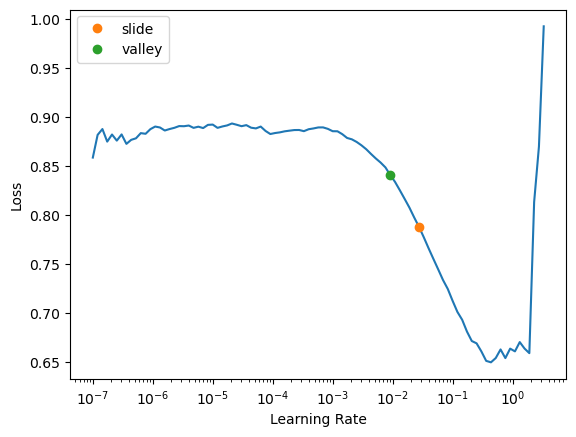

In [35]:
learner = deepl.create_model(training_data)
a = learner.lr_find(suggest_funcs=(slide, valley),stop_div=False)
learner.fit(10,lr=(a[1]+a[0])/2)

Path('models/final_dl.pth')

In [36]:
#instance = Instance.from_file("/home/mixto/repositories/newPRKP/data/L_300_179_1897.692.json")
#SolverCollection.gurobi_optimal(instance)

instance = Instance.generate(10000,100,seed=2123)


In [37]:
model: Solution = deepl.solve(instance,learner)
print(f"DLModel: of:{model.o} , time: {model.time}")

baldo = SolverCollection.baldo_ML(instance)
print(f"BaldoML: of:{baldo.o} , time: {baldo.time}")

optimal = SolverCollection.gurobi_optimal(instance)
print(f"Optimal: of:{optimal.o} , time: {optimal.time}")





DLModel: of:332341.65147020685 , time: 95.13958477973938
BaldoML: of:331480.98127374065 , time: 76.29827761650085
Optimal: of:331480.98127374065 , time: 1
